In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
possible_maximums = [6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4]

In [3]:
def perform_kmeans_clustering(csv_file,save_filename):
    df = pd.read_csv(csv_file, index_col=0)
    df = df.drop(['c_quantity'], axis=1)
    df = df.sample(n=10000, random_state=42)
    mapping_dict = {}
    for col in df.columns:
        if col.startswith('block_') and col.endswith('_c_quantity'):
            column_number = col[len('block_'):-len('_c_quantity')]
            new_column_name = f'S{column_number}'
            mapping_dict[col] = new_column_name

    df = df.rename(columns=mapping_dict)

    scaler = StandardScaler()
    normalized_answers = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    scaled_ans = normalized_answers.values
    pca = PCA(n_components=12)
    selected_features = pca.fit_transform(scaled_ans)
    model = KMeans()

    visualizer = KElbowVisualizer(model, k=(2, 20), timings=True)
    visualizer.fit(selected_features)

    k_n = visualizer.elbow_value_

    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []

    clustering = KMeans(n_clusters=k_n)
    labels = clustering.fit_predict(selected_features)
    silhouette_scores.append(silhouette_score(selected_features, labels))
    calinski_scores.append(calinski_harabasz_score(selected_features, labels))
    davies_bouldin_scores.append(davies_bouldin_score(selected_features, labels))

    df['KMeans_labels'] = labels

    silhouette_scores = [f"{score:.4f}" for score in silhouette_scores]
    calinski_scores = [f"{score:.4f}" for score in calinski_scores]
    davies_bouldin_scores = [f"{score:.4f}" for score in davies_bouldin_scores]

    evaluation_df = pd.DataFrame({
        'Method': ['KMeans'],
        'Silhouette Score': silhouette_scores,
        'Calinski-Harabasz Score': calinski_scores,
        'Davies-Bouldin Score': davies_bouldin_scores
    })

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Cluster visualization
    scatter = axes[0].scatter(selected_features[:, 0], selected_features[:, 1],
                              c=labels, cmap='nipy_spectral')
    axes[0].set_title('KMeans - Cluster Visualization')
    axes[0].set_xlabel('Feature 1')
    axes[0].set_ylabel('Feature 2')
    axes[0].legend(*scatter.legend_elements(), title='Clusters')

    # Cluster class distribution
    sns.histplot(x=labels, bins=len(np.unique(labels)), kde=False, ax=axes[1], hue=labels, palette='bright')
    axes[1].set_title('KMeans - Cluster Class Distribution')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Count')
    axes[0].text(0.5, -0.15, f'Silhouette Score: {silhouette_scores[0]}', transform=axes[0].transAxes, ha='center')
    axes[1].text(0.5, -0.15, f'Calinski-Harabasz Score: {calinski_scores[0]}\nDavies-Bouldin Score: {davies_bouldin_scores[0]}', transform=axes[1].transAxes, ha='center')

    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename, dpi=400)

    return df, evaluation_df, selected_features, k_n

In [12]:
def perform_agglomerative_clustering(df, selected_features, k_n, save_filename):
    # Find the best number of clusters using silhouette score
    max_clusters = 15

    # silhouette_scores = []
    # for n_clusters in range(4, max_clusters + 1):
    #     clustering = AgglomerativeClustering(n_clusters=n_clusters)
    #     labels = clustering.fit_predict(selected_features)
    #     score = silhouette_score(selected_features, labels)
    #     silhouette_scores.append(score)
    #
    # # # Determine the best number of clusters greater than or equal to 4 based on the silhouette score
    # best_n_clusters = np.argmax(silhouette_scores[2:]) + 4

    clustering = AgglomerativeClustering(n_clusters=k_n)
    labels = clustering.fit_predict(selected_features)

    silhouette_score_agglomerative = silhouette_score(selected_features, labels)
    calinski_score_agglomerative = calinski_harabasz_score(selected_features, labels)
    davies_bouldin_score_agglomerative = davies_bouldin_score(selected_features, labels)

    df['Agglomerative_labels'] = labels

    silhouette_score_agglomerative = f"{silhouette_score_agglomerative:.4f}"
    calinski_score_agglomerative = f"{calinski_score_agglomerative:.4f}"
    davies_bouldin_score_agglomerative = f"{davies_bouldin_score_agglomerative:.4f}"

    evaluation_df_agglomerative = pd.DataFrame({
        'Method': ['Agglomerative'],
        'Silhouette Score': [silhouette_score_agglomerative],
        'Calinski-Harabasz Score': [calinski_score_agglomerative],
        'Davies-Bouldin Score': [davies_bouldin_score_agglomerative]
    })

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(selected_features[:, 0], selected_features[:, 1],
                          c=labels, cmap='nipy_spectral')
    ax1.set_title(f'Agglomerative Clustering - Cluster Visualization')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend(*scatter.legend_elements(), title='Clusters')

    ax2 = fig.add_subplot(122)
    sns.histplot(x=labels, bins=len(np.unique(labels)), kde=False, ax=ax2, hue=labels,  palette='bright', )
    ax2.set_title(f'Agglomerative Clustering - Cluster Class Distribution')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Count')
    ax1.text(0.5, -0.2, f'Silhouette Score: {silhouette_score_agglomerative}', transform=ax1.transAxes, ha='center')
    ax2.text(0.5, -0.2, f'Calinski-Harabasz Score: {calinski_score_agglomerative}\nDavies-Bouldin Score: {davies_bouldin_score_agglomerative}', transform=ax2.transAxes, ha='center')

    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename, dpi=400)
    plt.show()

    return df, evaluation_df_agglomerative

In [5]:
def normalize_values(values):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_values = scaler.fit_transform(values.flatten().reshape(-1, 1))

    return normalized_values.reshape(values.shape)

def generate_cluster_heatmaps(df, method, possible_maximums, save_filename=None):

    section_numbers = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12']
    section_order = sorted(section_numbers, key=lambda x: int(x[1:]))

    if method == 'KMeans':
        indd = 'KMeans_labels'
    else:
        indd = 'Agglomerative_labels'

    cluster_corr = df.pivot_table(index=indd, columns=None, values=section_numbers, aggfunc='mean')
    cluster_corr = cluster_corr[section_order]

    normalized_cluster_corr = normalize_values(cluster_corr.values, possible_maximums)
    normalized_cluster_corr = pd.DataFrame(normalized_cluster_corr, index=cluster_corr.index, columns=cluster_corr.columns)

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(normalized_cluster_corr, cmap='plasma', annot=True, fmt=".1f", linewidths=0.5)
    plt.title('Cluster Labels Correlation with Section Results')
    plt.xlabel('Section Numbers')
    plt.ylabel('Cluster Labels')

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va="center")
    ax.set_yticklabels([str(int(label.get_text()) + 1) for label in ax.get_yticklabels()])

    plt.suptitle(f"Correlation Heat Map for Different Clusters - {method.capitalize()}", fontsize=16)
    plt.tight_layout()
    if save_filename:
        plt.savefig(save_filename, dpi=400)
    plt.show()

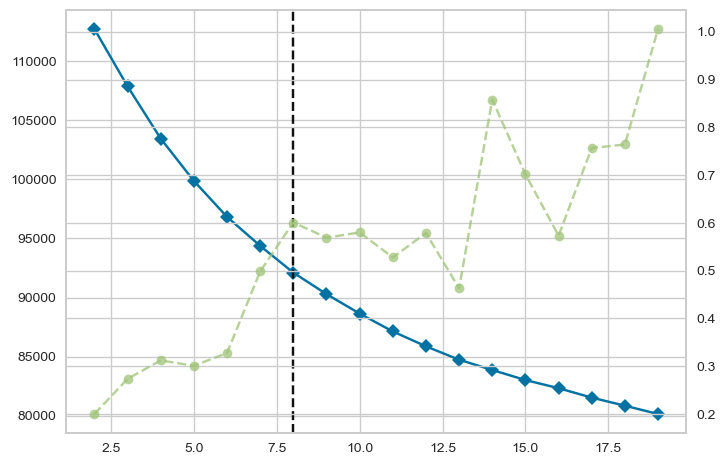

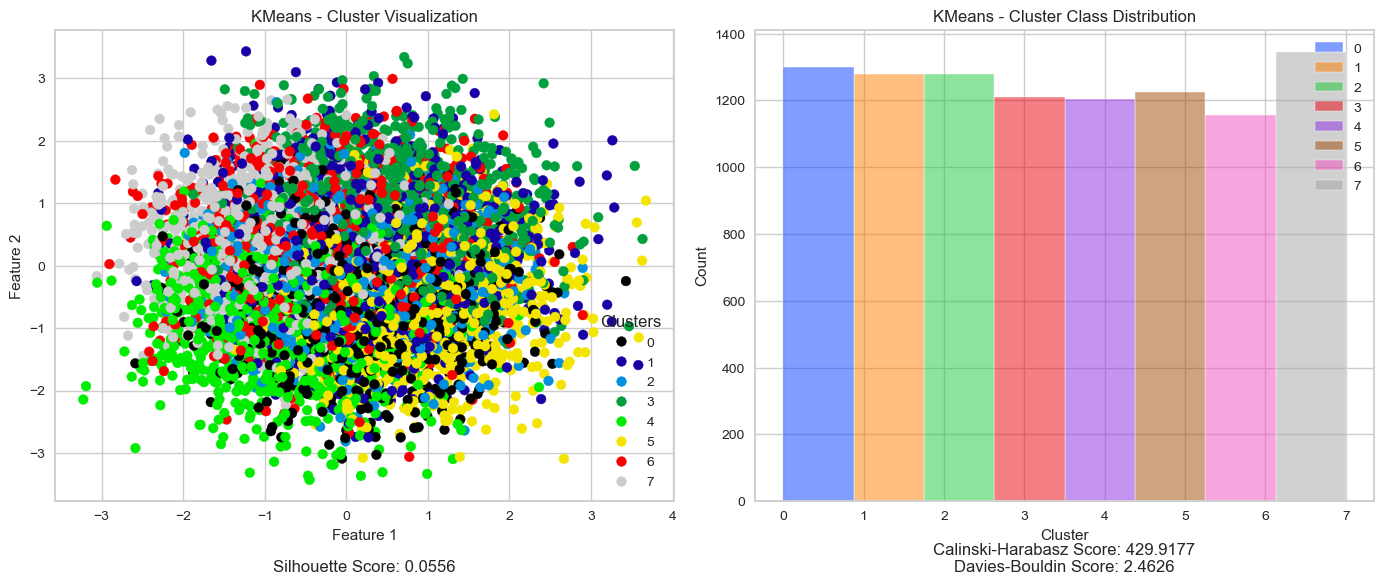

In [6]:
csv_file_path_0 = 'csv/cert_test_data_extended_0.csv'
df0, evaluation_df0, selected_features, k_n = perform_kmeans_clustering(csv_file_path_0, 'KMeans Visualization - 0.png')
plt.show()

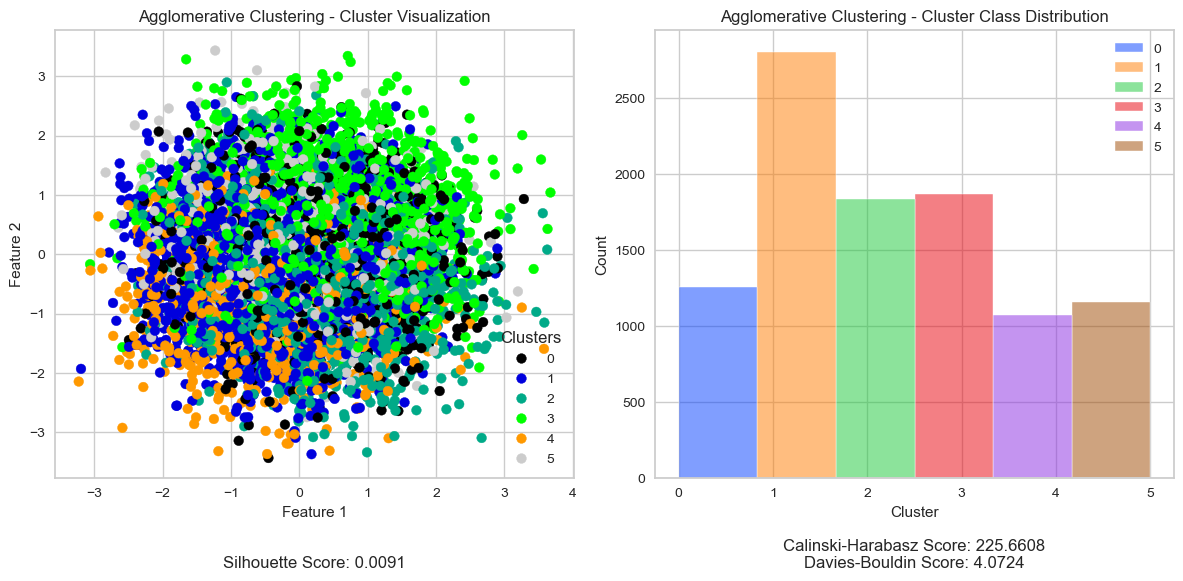

In [14]:
df0, evaluation_df0_h = perform_agglomerative_clustering(df0, selected_features, 6, 'Hierarchical Visualization - 0.png')
plt.show()

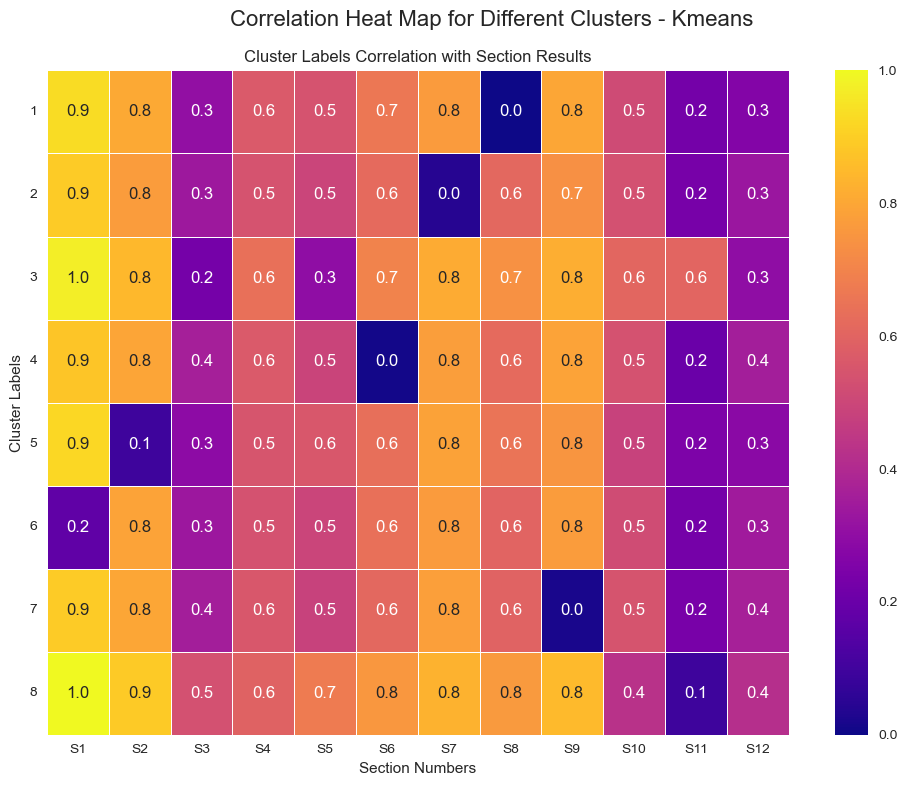

In [8]:
generate_cluster_heatmaps(df0, 'KMeans', possible_maximums, 'HeatMap - 0 - Kmeans.png')

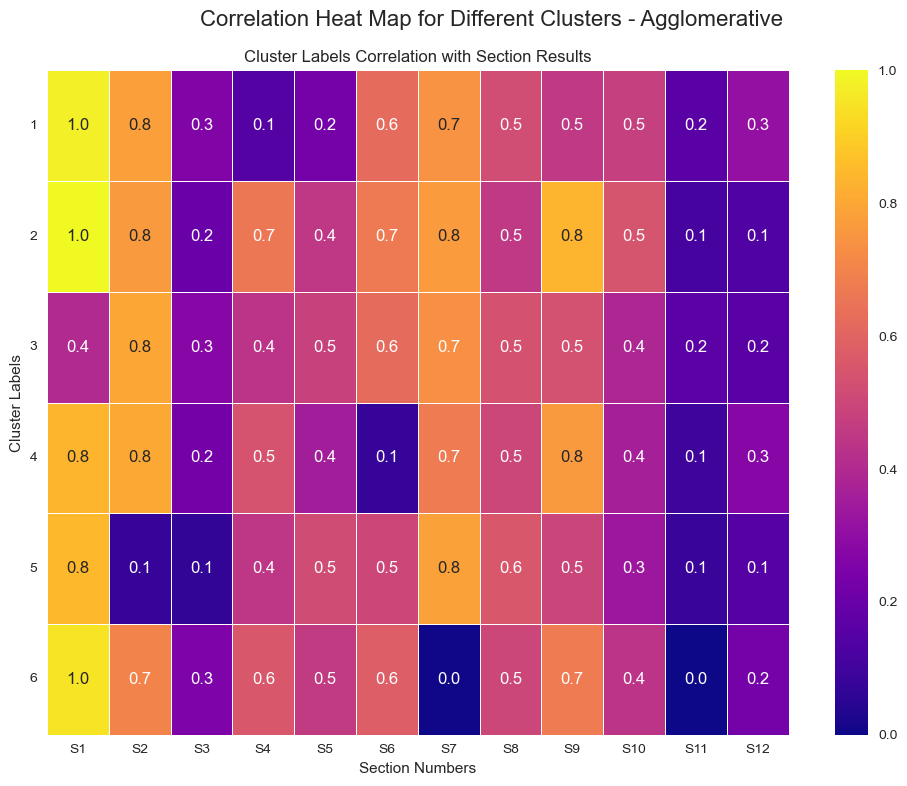

In [15]:
generate_cluster_heatmaps(df0, 'Agglomerative', possible_maximums, 'HeatMap - 0 - Hierarchical.png')

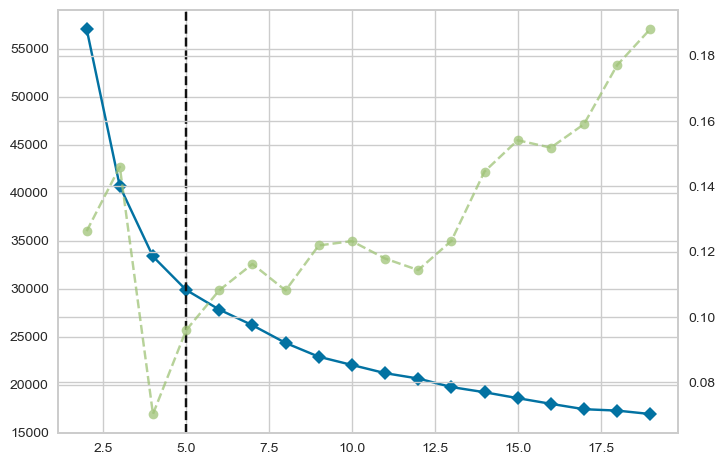

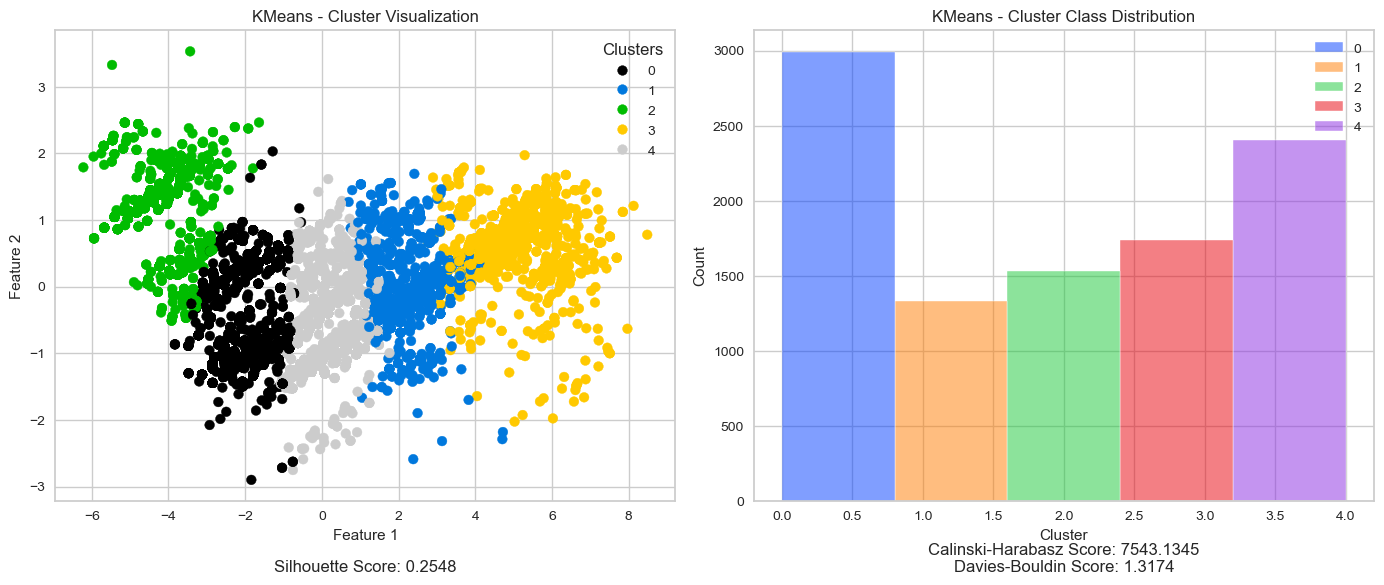

In [16]:
csv_file_path_1 = 'csv/cert_test_data_extended_1.csv'
df1, evaluation_df1, selected_features1, k_n1 = perform_kmeans_clustering(csv_file_path_1, 'KMeans Visualization - 1.png')
plt.show()

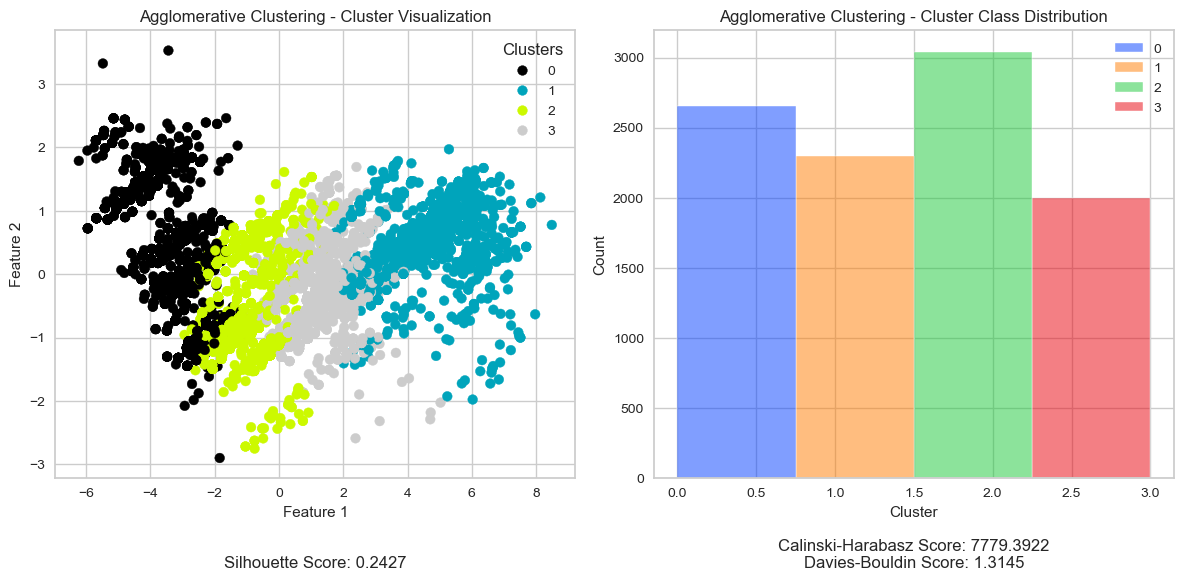

In [17]:
df1, evaluation_df1_h = perform_agglomerative_clustering(df1, selected_features1, 4, 'Hierarchical Visualization - 1.png')
plt.show()

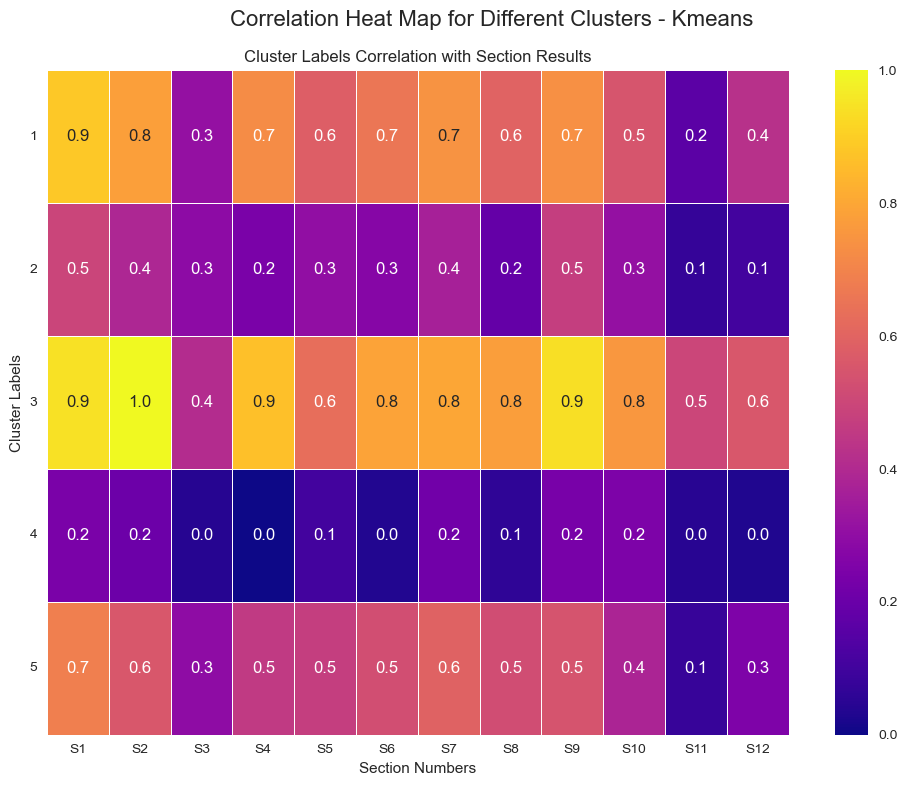

In [18]:
generate_cluster_heatmaps(df1, 'KMeans', possible_maximums, 'HeatMap - 1 - Kmeans.png')

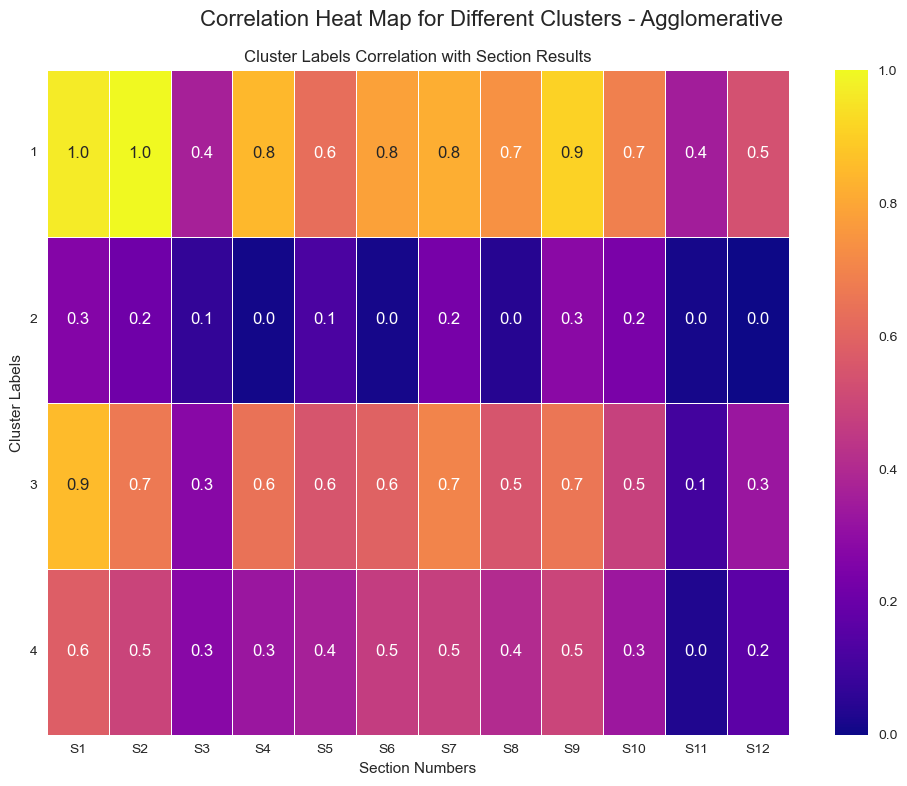

In [19]:
generate_cluster_heatmaps(df1, 'Agglomerative', possible_maximums, 'HeatMap - 1 - Hierarchical.png')

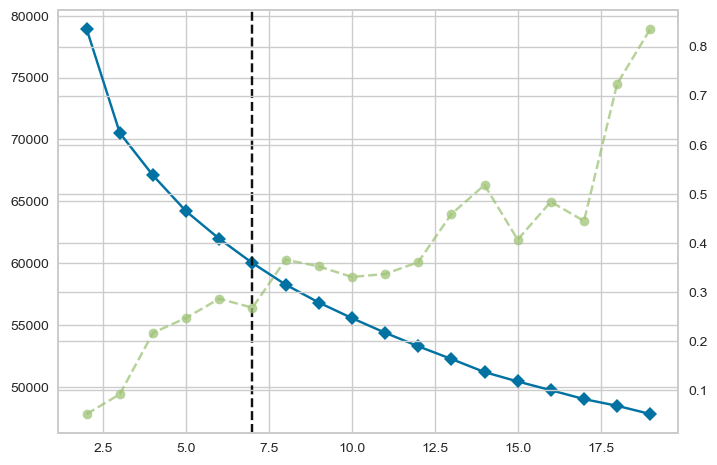

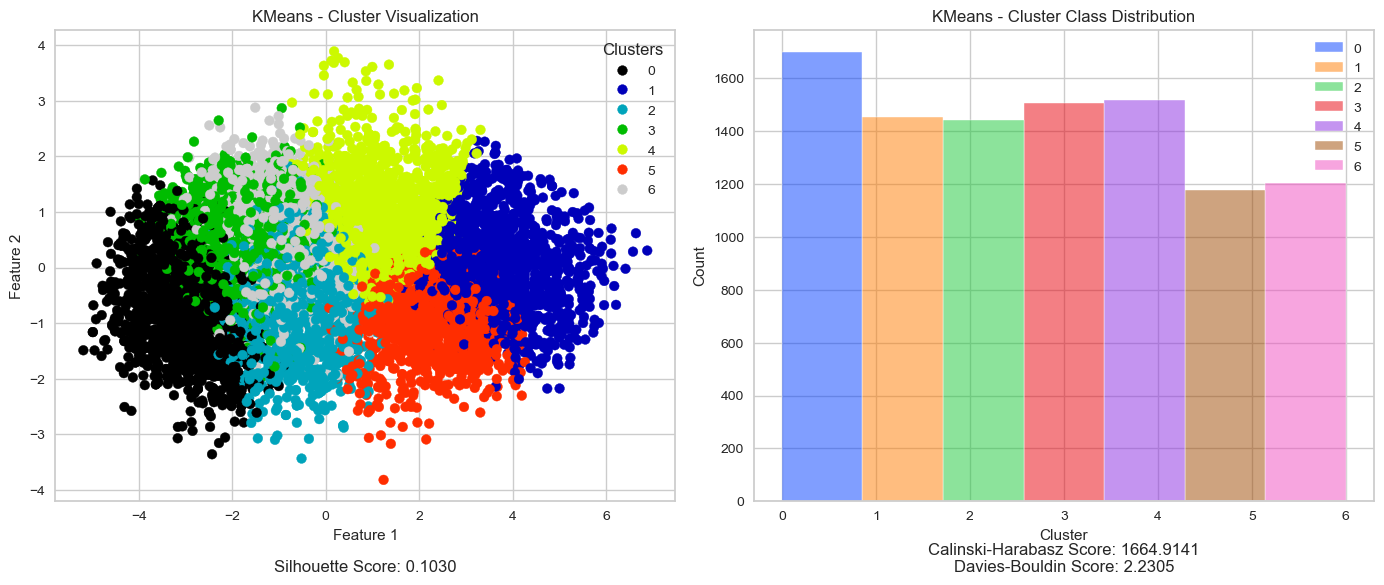

In [20]:
csv_file_path_2 = 'csv/cert_test_data_extended_2.csv'
df2, evaluation_df2, selected_features2, k_n2 = perform_kmeans_clustering(csv_file_path_2, 'KMeans Visualization - 2.png')
plt.show()

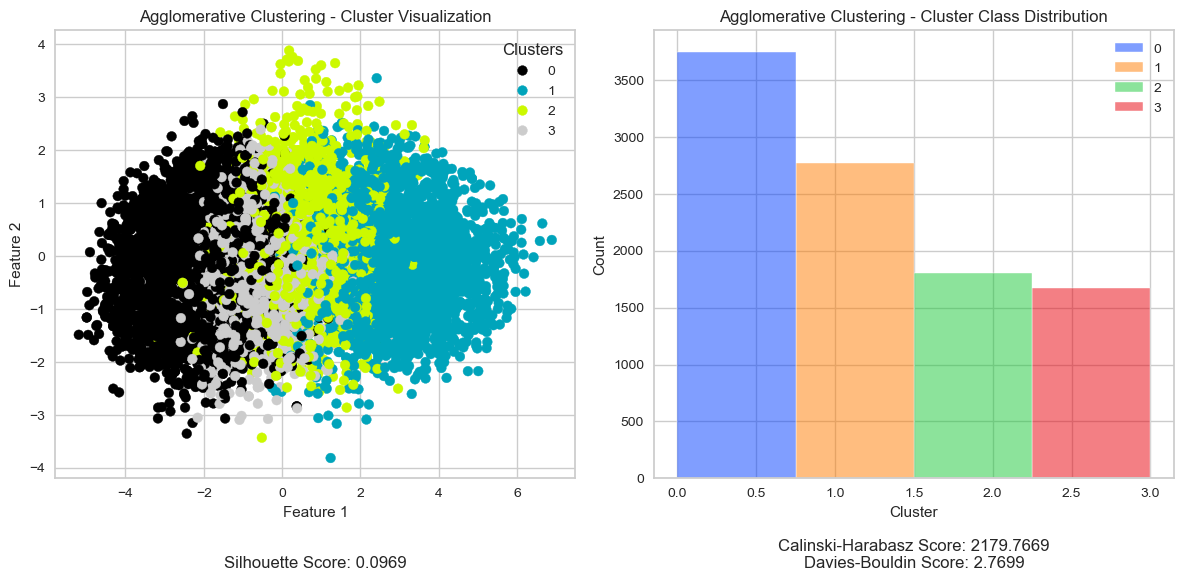

In [21]:
df2, evaluation_df2_h = perform_agglomerative_clustering(df2, selected_features2, 4, 'Hierarchical Visualization - 2.png')
plt.show()

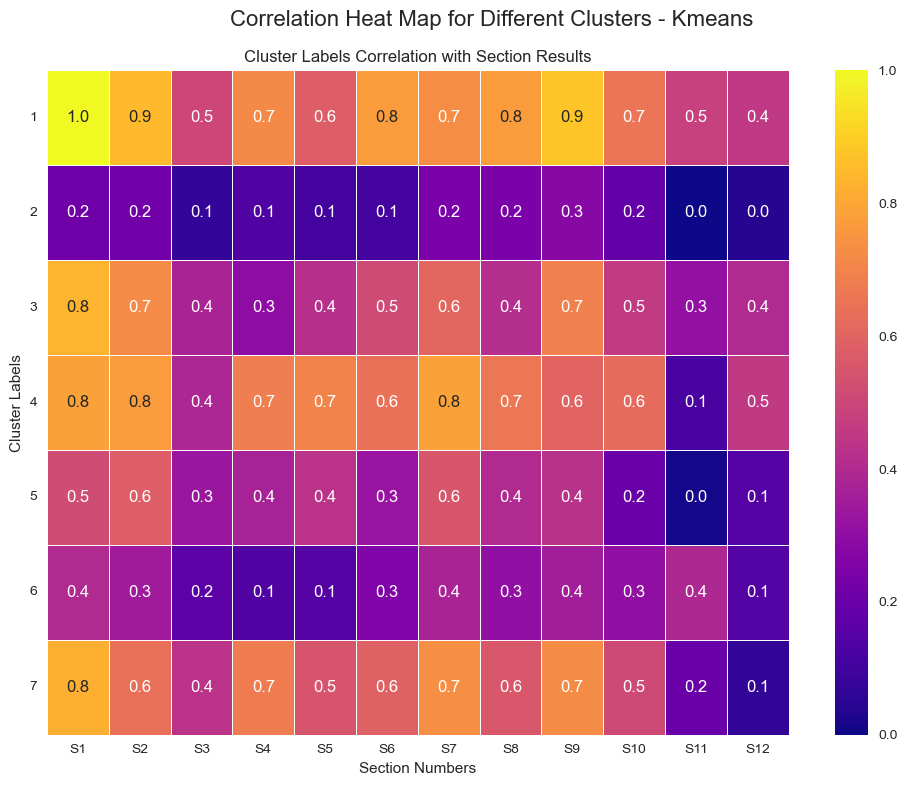

In [22]:
generate_cluster_heatmaps(df2, 'KMeans', possible_maximums, 'HeatMap - 2 - Kmeans.png')

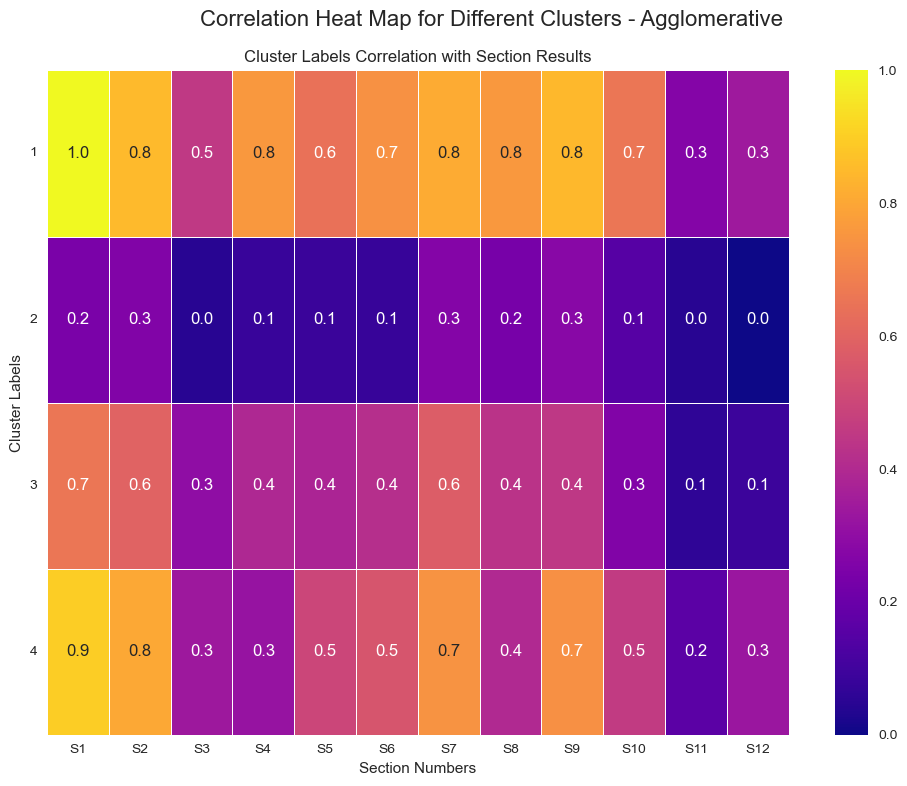

In [23]:
generate_cluster_heatmaps(df2, 'Agglomerative', possible_maximums, 'HeatMap - 2 - Hierarchical.png')

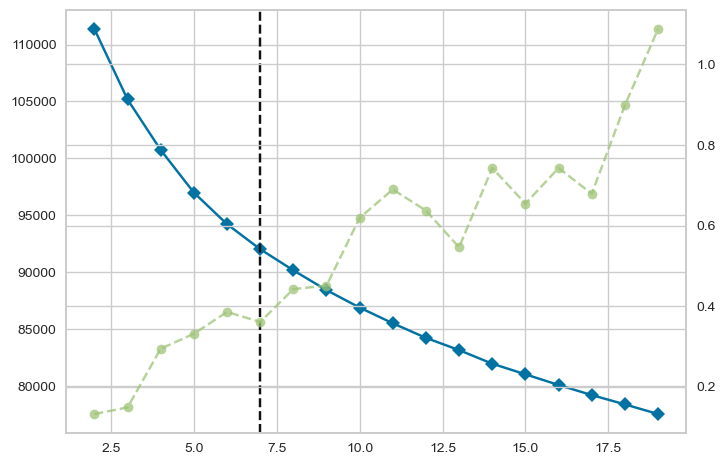

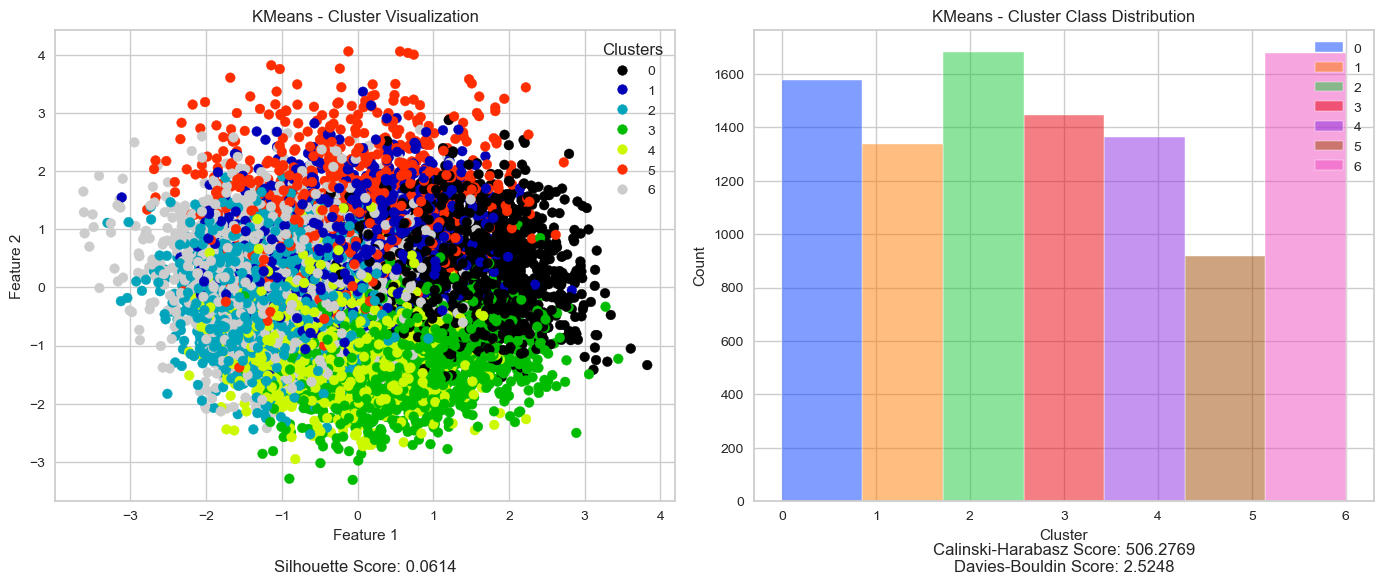

In [24]:
csv_file_path_3 = 'csv/cert_test_data_extended_3.csv'
df3, evaluation_df3, selected_features3, k_n3 = perform_kmeans_clustering(csv_file_path_3, 'KMeans Visualization - 3.png')
plt.show()

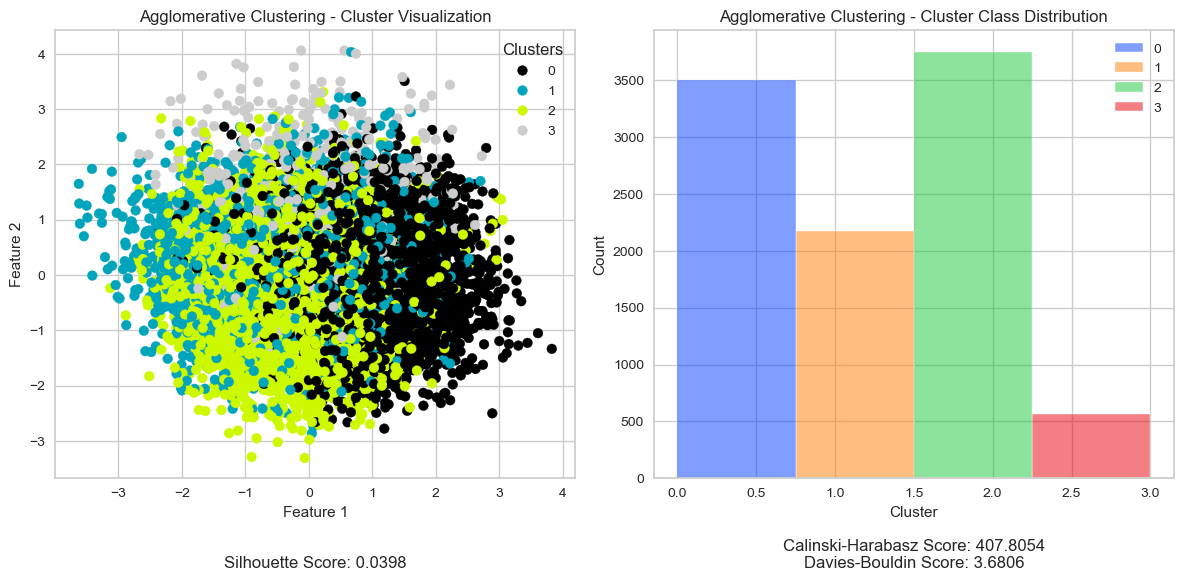

In [25]:
df3, evaluation_df3_h = perform_agglomerative_clustering(df3, selected_features3, 4, 'Hierarchical Visualization - 3.png')
plt.show()

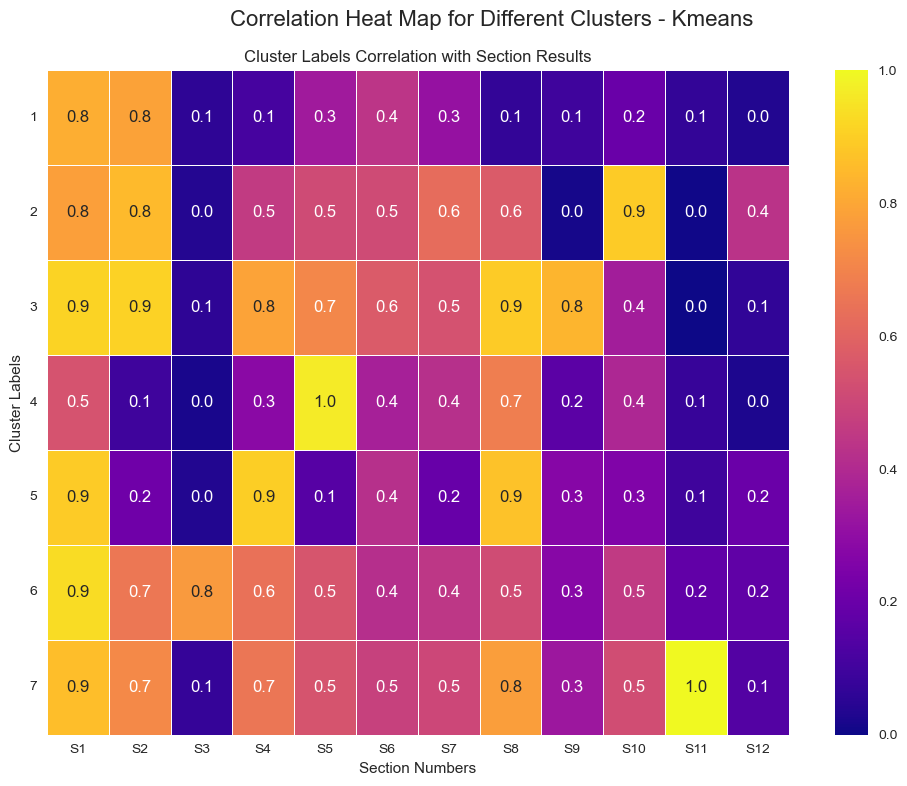

In [26]:
generate_cluster_heatmaps(df3, 'KMeans', possible_maximums, 'HeatMap - 3 - Kmeans.png')

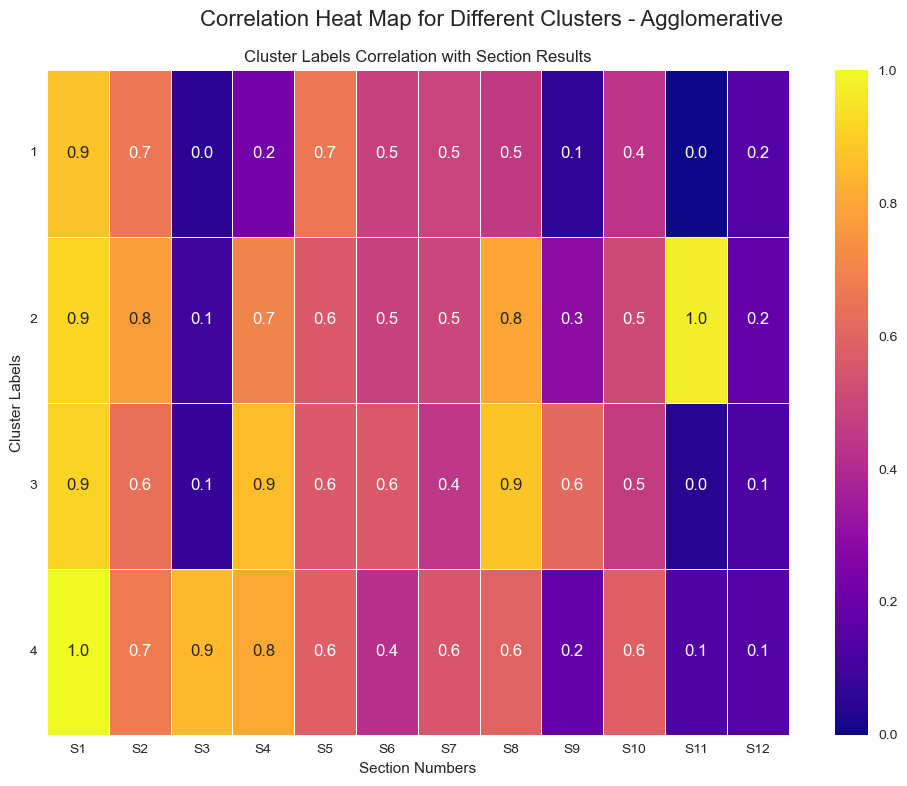

In [27]:
generate_cluster_heatmaps(df3, 'Agglomerative', possible_maximums,
                          'HeatMap - 3 - Hierarchical.png')